In [500]:
import polars as pl 
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 


dataPath = "./home-credit-credit-risk-model-stability/"

In [501]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [502]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [503]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [504]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [505]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [506]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.8, random_state=1)
#case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
#base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)


#for df in [X_train, X_valid, X_test]:
#    df = convert_strings(df)

for df in [X_train, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

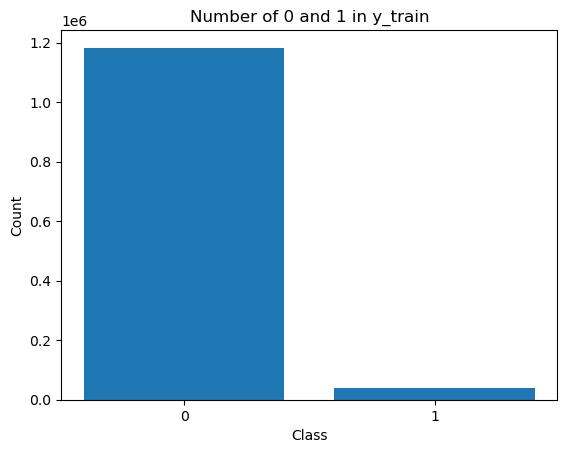

In [507]:
# Count the number of 0s and 1s
counts = y_train.value_counts()

# Create a bar chart
plt.bar(counts.index, counts.values)

# Label the x-axis and y-axis
plt.xlabel('Class')
plt.ylabel('Count')

# Add a title
plt.title('Number of 0 and 1 in y_train')

# Specify the x-axis tick marks
plt.xticks([0, 1])

# Show the plot
plt.show()

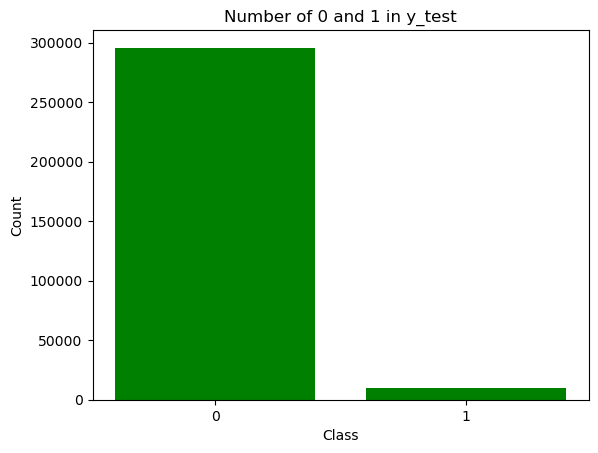

In [508]:
# Count the number of 0s and 1s
counts = y_test.value_counts()

# Create a bar chart
plt.bar(counts.index, counts.values, color=[ 'green'])

# Label the x-axis and y-axis
plt.xlabel('Class')
plt.ylabel('Count')

# Add a title
plt.title('Number of 0 and 1 in y_test')

# Specify the x-axis tick marks
plt.xticks([0, 1])

# Show the plot
plt.show()

## Data Cleaning - X_train

<Axes: >

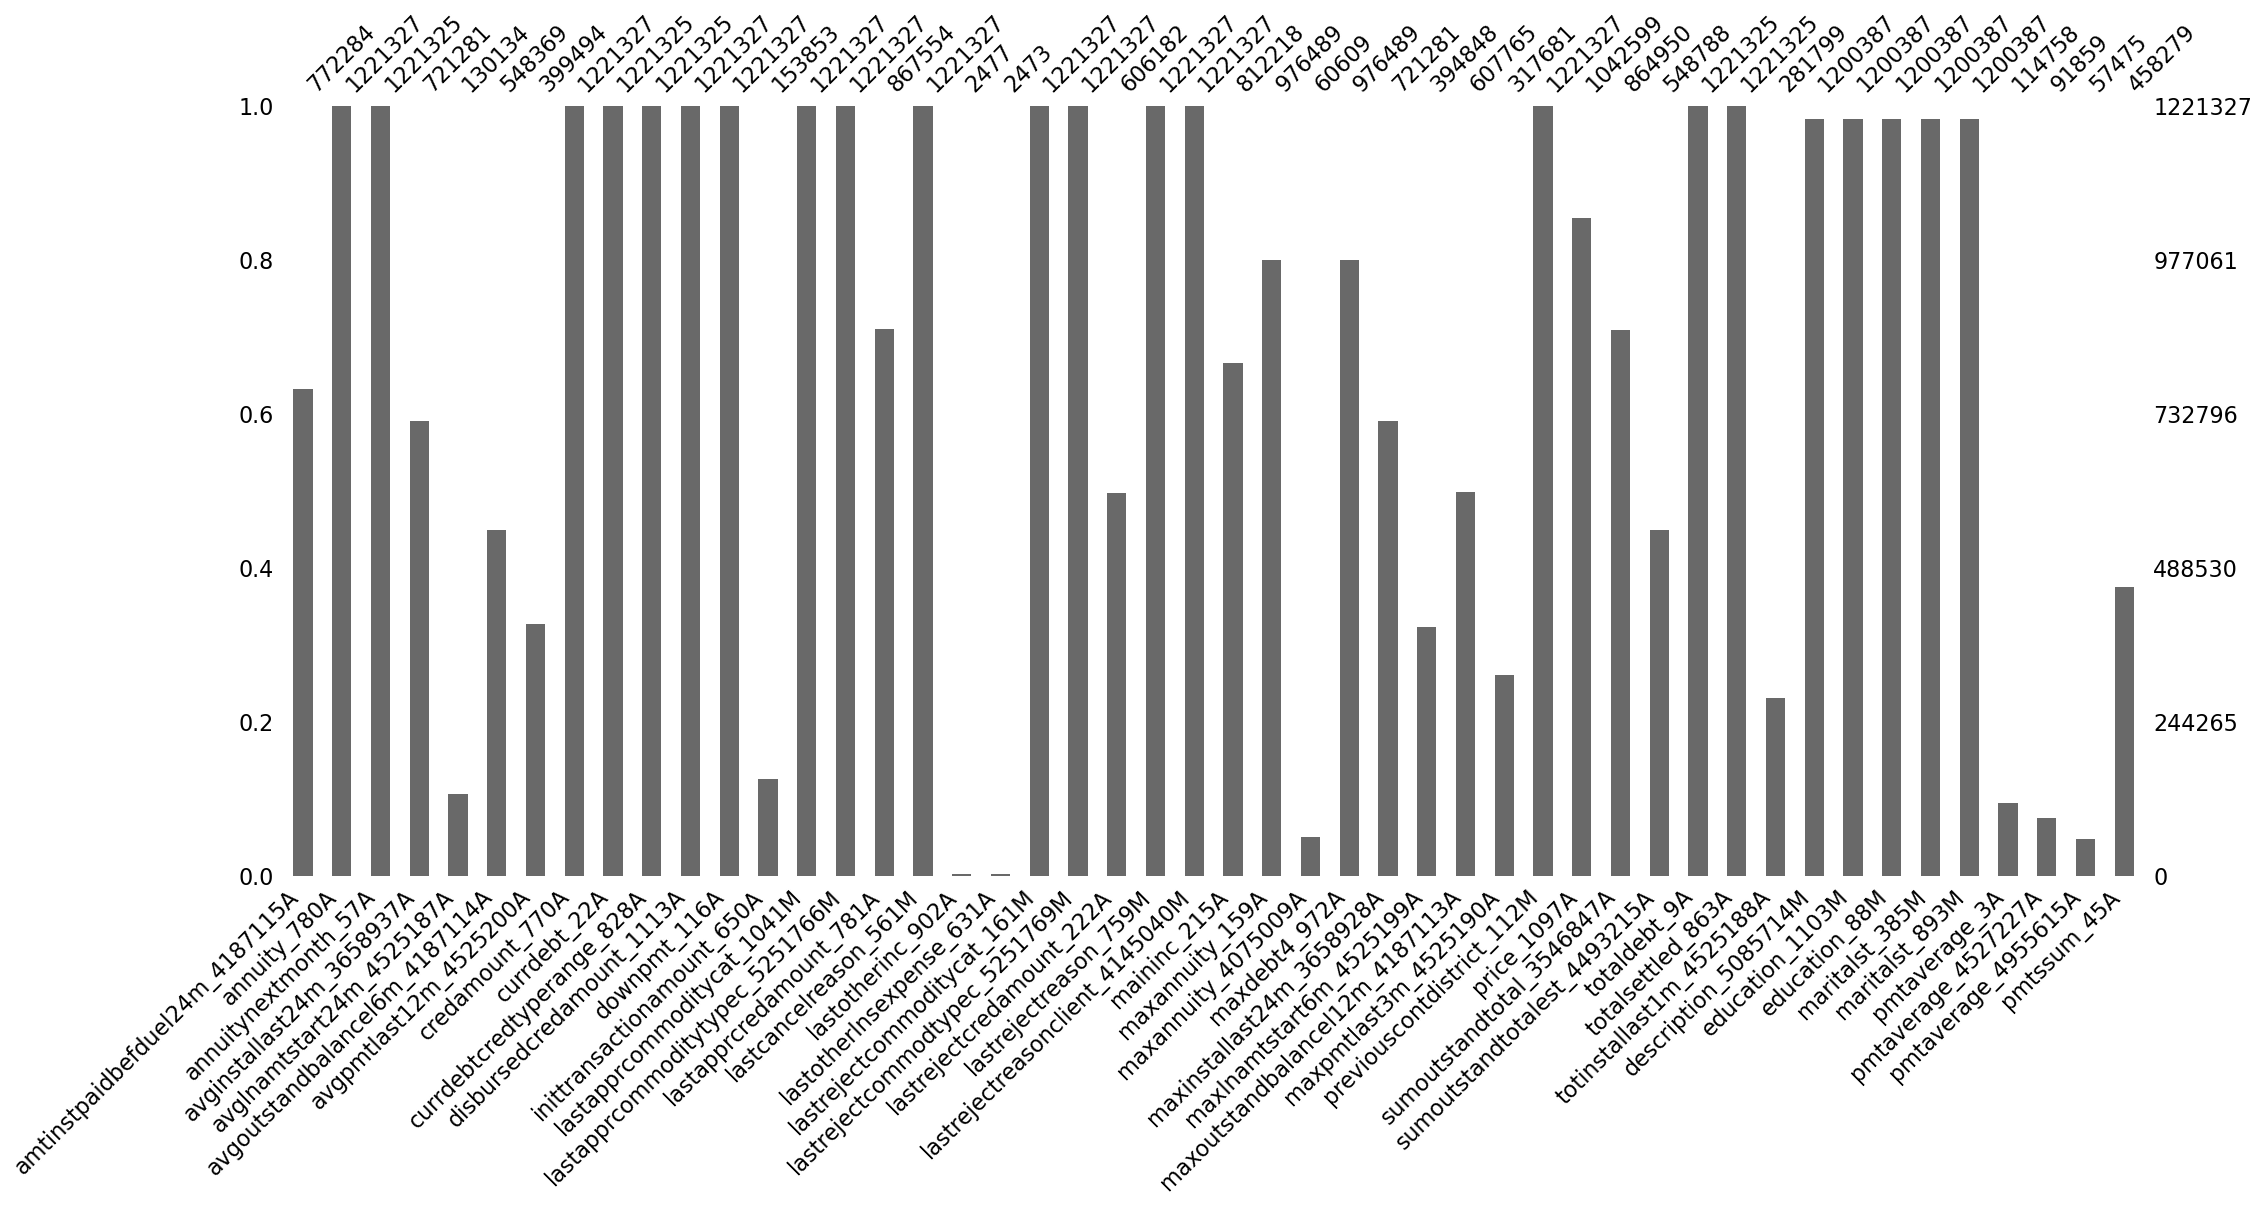

In [509]:
msno.bar(X_train)

In [510]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['Column', 'Min Value'])

# Iterate over the columns
for col in X_train.columns:
    # Check if the column contains any NaN values
    if X_train[col].isna().any():
        # Get the minimum value in the column
        min_value = X_train[col].min()
        # Create a DataFrame with the column name and minimum value
        new_row = pd.DataFrame({'Column': [col], 'Min Value': [min_value]})
        # Concatenate the new row to the result DataFrame
        result = pd.concat([result, new_row], ignore_index=True)

# Display the result
print(result)

                             Column  Min Value
0    amtinstpaidbefduel24m_4187115A        0.0
1              annuitynextmonth_57A        0.0
2         avginstallast24m_3658937A        0.0
3         avglnamtstart24m_4525187A        0.0
4    avgoutstandbalancel6m_4187114A -7588198.5
5            avgpmtlast12m_4525200A        0.0
6                      currdebt_22A        0.0
7        currdebtcredtyperange_828A        0.0
8        inittransactionamount_650A        0.0
9           lastapprcredamount_781A        0.0
10                lastotherinc_902A        0.0
11         lastotherlnsexpense_631A        0.0
12        lastrejectcredamount_222A        0.0
13                     maininc_215A        0.0
14                  maxannuity_159A        0.0
15              maxannuity_4075009A      600.0
16                    maxdebt4_972A        0.0
17        maxinstallast24m_3658928A        0.0
18         maxlnamtstart6m_4525199A        0.0
19  maxoutstandbalancel12m_4187113A -7588198.5
20           

/var/folders/60/4pfs6t995613vlvnf3xtprtr0000gn/T/ipykernel_5186/3037250746.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index=True)


In [511]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64'])

# Find the indices of the rows with negative values in any numeric column
negative_indices = numeric_cols[numeric_cols.lt(0).any(axis=1)].index

# Remove these rows from X_train
X_train = X_train.drop(negative_indices)

# Remove the corresponding rows from y_test and base_train
y_train = y_train.drop(negative_indices)
base_train = base_train.drop(negative_indices)

In [512]:
#remove that strange row with strange nan values
# Find the indices where 'description_5085714M' is NaN
nan_indices = X_train[X_train['description_5085714M'].isna()].index

# Drop these indices from the dataframes
X_train = X_train.drop(nan_indices)
y_train = y_train.drop(nan_indices)
base_train = base_train.drop(nan_indices)

In [513]:
# last but not least, fill in Na with -1 values
# Fill NaN values with -1 in the specified columns
for col in X_train.columns:
    if isinstance(X_test[col].dtype, pd.CategoricalDtype):
        X_train[col] = X_train[col].cat.add_categories([-1])
        X_train[col].fillna(-1, inplace=True)

X_train = X_train.fillna(-1)

X_train = X_train.fillna(-1)


<Axes: >

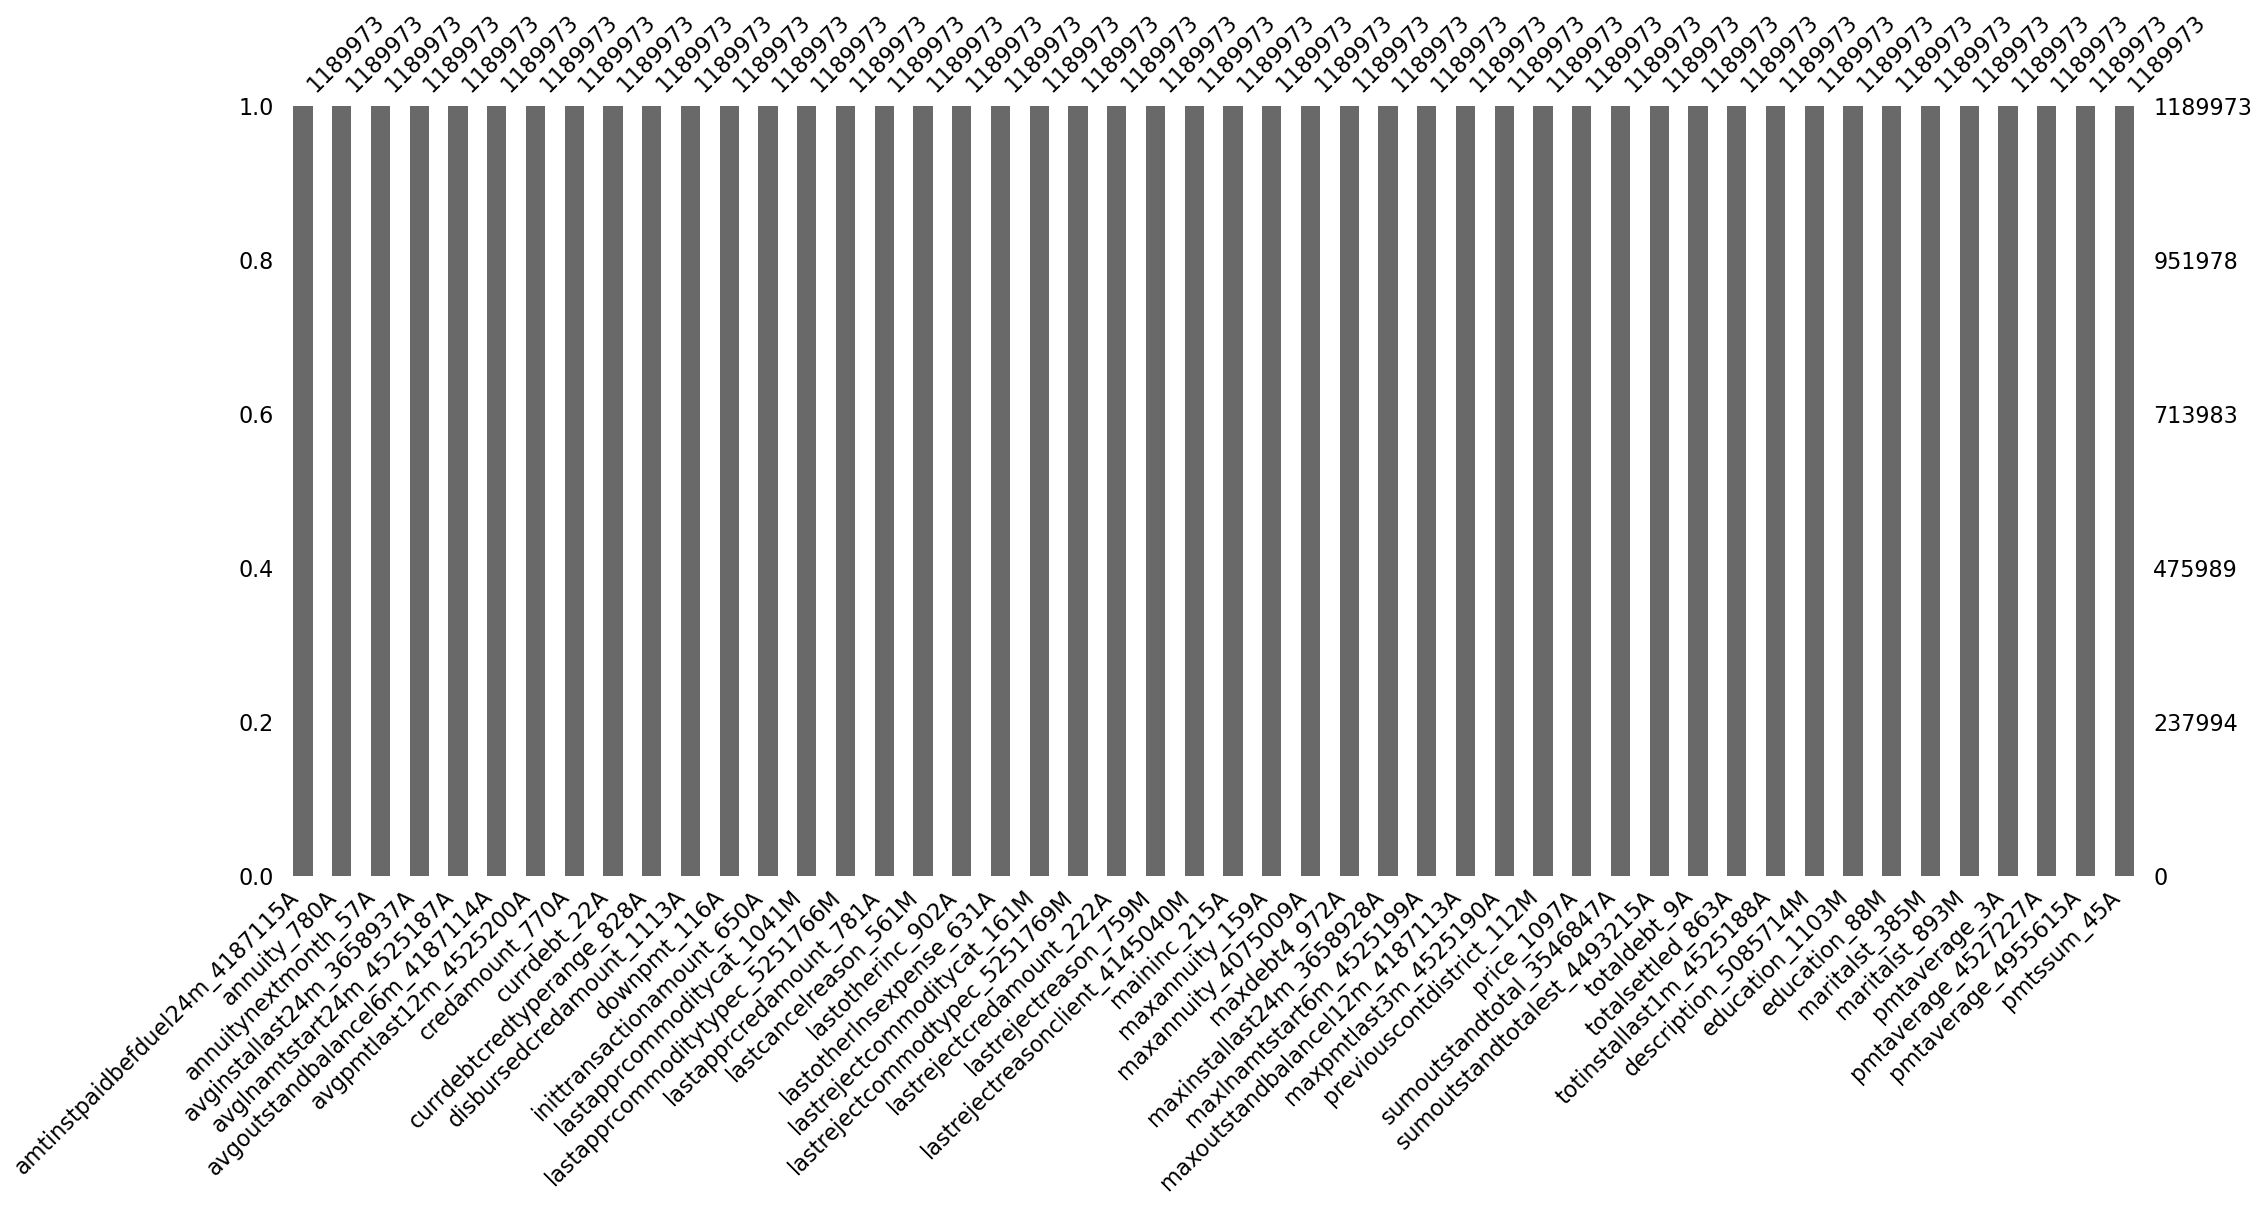

In [514]:
msno.bar(X_train)

## Data Cleaning - X_test

<Axes: >

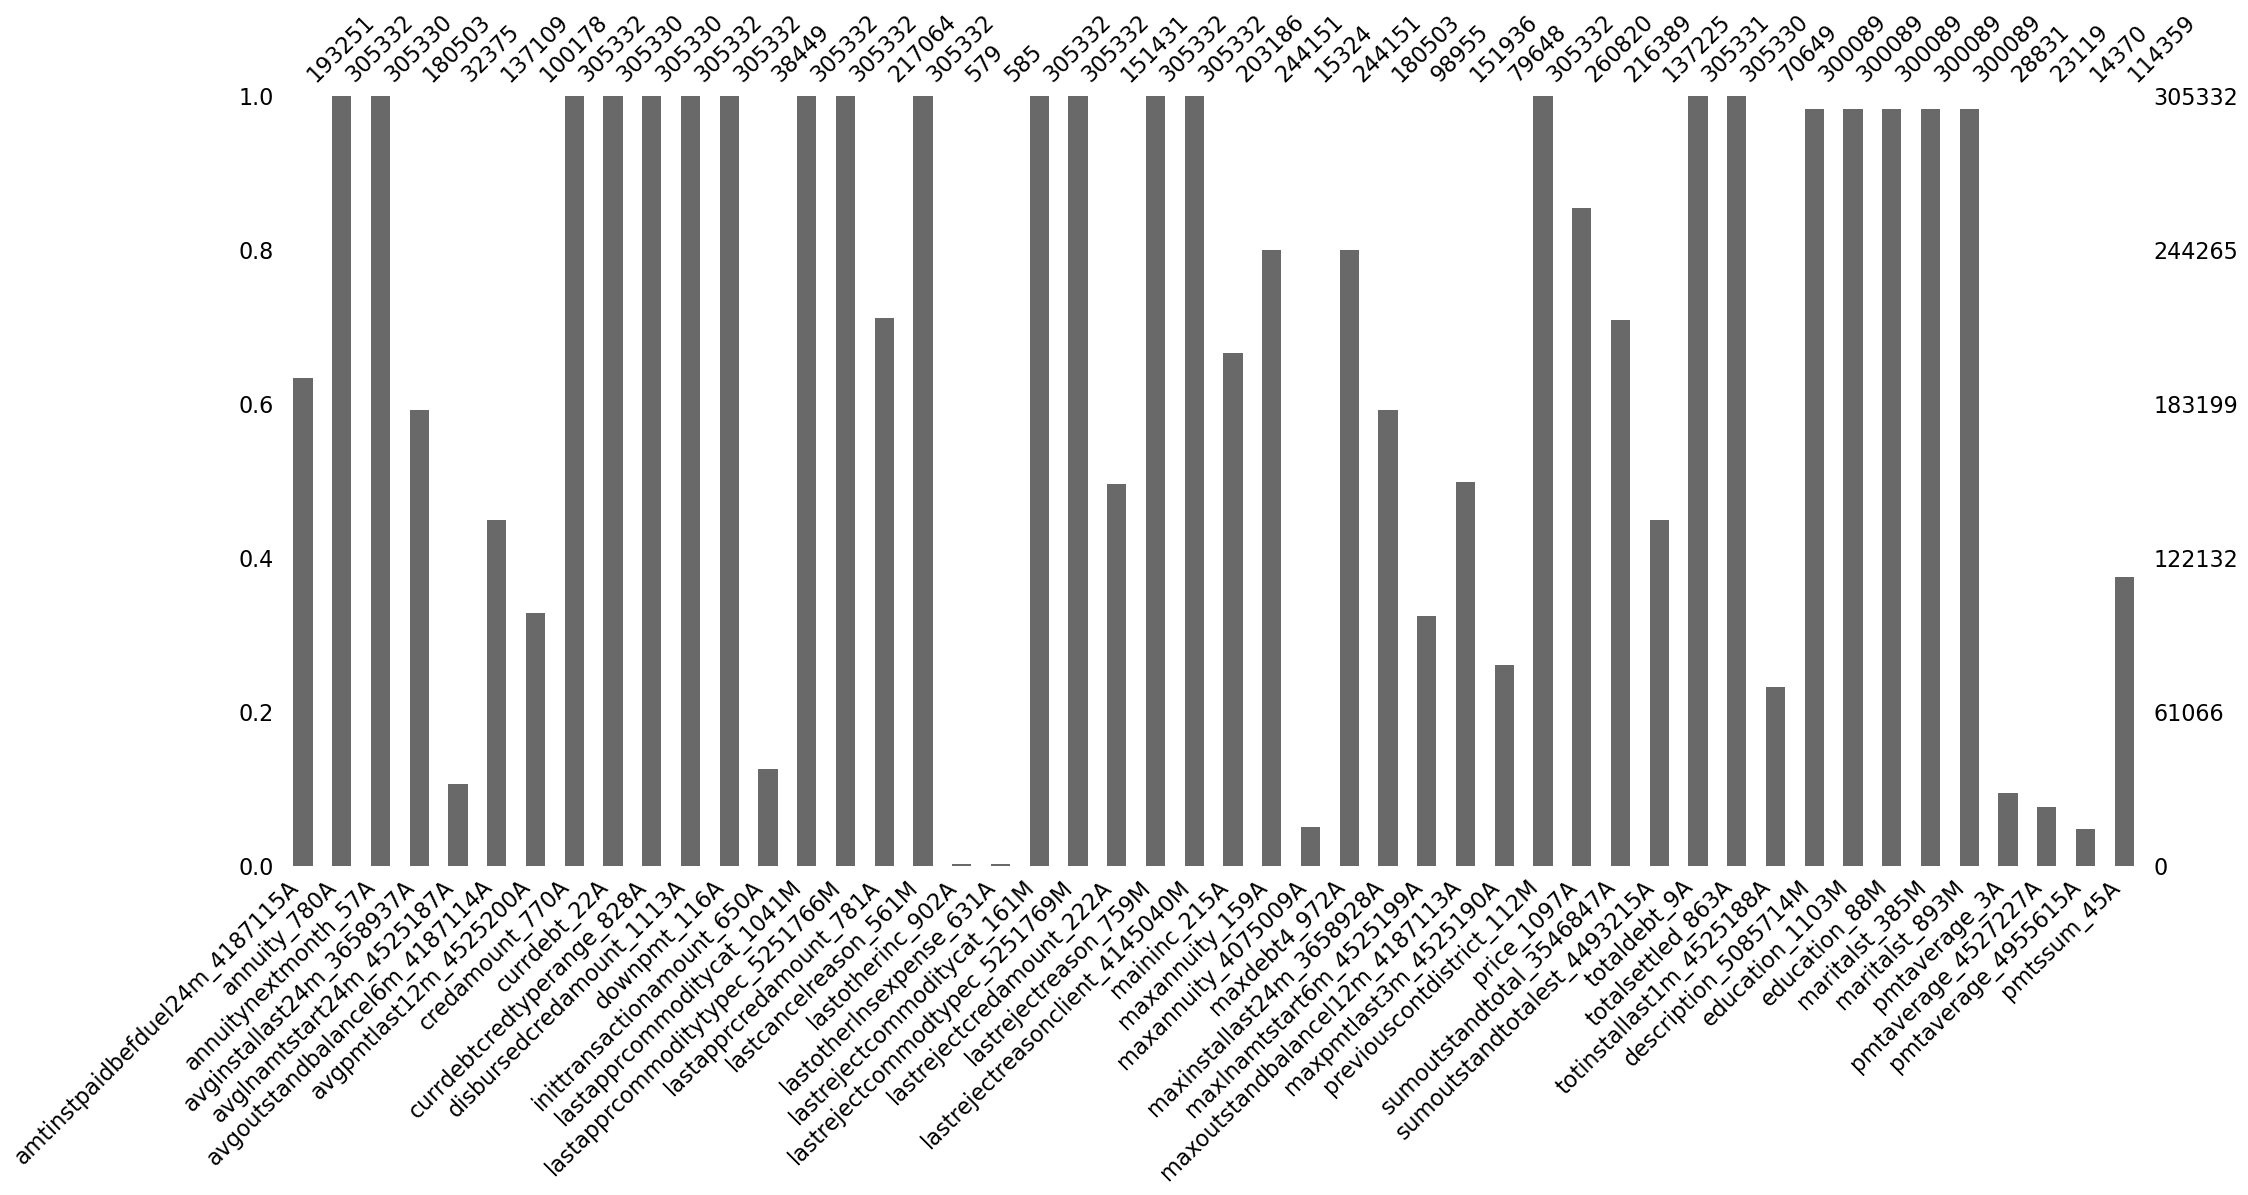

In [515]:
msno.bar(X_test)

In [516]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['Column', 'Min Value'])

# Iterate over the columns
for col in X_test.columns:
    # Check if the column contains any NaN values
    if X_test[col].isna().any():
        # Get the minimum value in the column
        min_value = X_test[col].min()
        # Create a DataFrame with the column name and minimum value
        new_row = pd.DataFrame({'Column': [col], 'Min Value': [min_value]})
        # Concatenate the new row to the result DataFrame
        result = pd.concat([result, new_row], ignore_index=True)

# Display the result
print(result)

                             Column  Min Value
0    amtinstpaidbefduel24m_4187115A        0.0
1              annuitynextmonth_57A        0.0
2         avginstallast24m_3658937A        0.0
3         avglnamtstart24m_4525187A        0.0
4    avgoutstandbalancel6m_4187114A -2000000.0
5            avgpmtlast12m_4525200A        0.0
6                      currdebt_22A        0.0
7        currdebtcredtyperange_828A        0.0
8        inittransactionamount_650A        0.0
9           lastapprcredamount_781A        0.0
10                lastotherinc_902A        0.0
11         lastotherlnsexpense_631A        0.0
12        lastrejectcredamount_222A        0.0
13                     maininc_215A      0.038
14                  maxannuity_159A        0.0
15              maxannuity_4075009A      620.0
16                    maxdebt4_972A        0.0
17        maxinstallast24m_3658928A        0.0
18         maxlnamtstart6m_4525199A        0.0
19  maxoutstandbalancel12m_4187113A -2000000.0
20           

/var/folders/60/4pfs6t995613vlvnf3xtprtr0000gn/T/ipykernel_5186/1794353418.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index=True)


In [517]:
#fill NaN values with -1 in the specified columns for datafraem X_test
"""
X_test['lastotherinc_902A'] = X_test['lastotherinc_902A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_test['lastotherlnsexpense_631A'] = X_test['lastotherlnsexpense_631A'].fillna(-1) #Monthly expenses on other loans from the last application.
X_test['amtinstpaidbefduel24m_4187115A'] = X_test['amtinstpaidbefduel24m_4187115A'].fillna(-1) #Number of instalments paid before due date in the last 24 months.
X_test['avglnamtstart24m_4525187A'] = X_test['avglnamtstart24m_4525187A'].fillna(-1) #Average loan amount in the last 24 months.
X_test['avginstallast24m_3658937A'] = X_test['avginstallast24m_3658937A'].fillna(-1) #Average instalments paid by the client over the past 24 months.
X_test['avgoutstandbalancel6m_4187114A'] = X_test['avgoutstandbalancel6m_4187114A'].fillna(-1) #Average outstanding balance of applicant for the last 6 months.
X_test['avgpmtlast12m_4525200A'] = X_test['avgpmtlast12m_4525200A'].fillna(-1) #Average of payments made by the client in the last 12 months.
X_test['inittransactionamount_650A'] = X_test['inittransactionamount_650A'].fillna(-1) #Initial transaction amount of the credit application.
X_test['lastapprcredamount_781A'] = X_test['lastapprcredamount_781A'].fillna(-1) #Credit amount from the client's last application.
X_test['lastrejectcredamount_222A'] = X_test['lastrejectcredamount_222A'].fillna(-1) #Credit amount on last rejected application.
X_test['maininc_215A'] = X_test['maininc_215A'].fillna(-1) #Client's primary income amount.
X_test['maxannuity_159A'] = X_test['maxannuity_159A'].fillna(-1) #Maximum annuity previously obtained by client.
X_test['maxannuity_4075009A'] = X_test['maxannuity_4075009A'].fillna(-1) #Maximal annuity offered to the client in the current application.
X_test['maxdebt4_972A'] = X_test['maxdebt4_972A'].fillna(-1) #Maximal principal debt of the client in the history older than 4 months.
X_test['maxinstallast24m_3658928A'] = X_test['maxinstallast24m_3658928A'].fillna(-1) #Maximum instalment in the last 24 months.
X_test['maxlnamtstart6m_4525199A'] = X_test['maxlnamtstart6m_4525199A'].fillna(-1) #Maximum loan amount started in the last 6 months.
X_test['maxoutstandbalancel12m_4187113A'] = X_test['maxoutstandbalancel12m_4187113A'].fillna(-1) #Maximum outstanding balance in the last 12 months.
X_test['maxpmtlast3m_4525190A'] = X_test['maxpmtlast3m_4525190A'].fillna(-1) #Maximum payment made by the client in the last 3 months.
X_test['price_1097A'] = X_test['price_1097A'].fillna(-1) #Credit price.
X_test['sumoutstandtotal_3546847A'] = X_test['sumoutstandtotal_3546847A'].fillna(-1) #Sum of total outstanding amount.
X_test['sumoutstandtotalest_4493215A'] = X_test['sumoutstandtotalest_4493215A'].fillna(-1) #Sum of total outstanding amount.
X_test['totinstallast1m_4525188A'] = X_test['totinstallast1m_4525188A'].fillna(-1) #Total amount of monthly instalments paid in the previous month.
X_test['pmtaverage_3A'] = X_test['pmtaverage_3A'].fillna(-1) #Average of tax deductions.
X_test['pmtaverage_4527227A'] = X_test['pmtaverage_4527227A'].fillna(-1) #Average of tax deductions.
X_test['pmtaverage_4955615A'] = X_test['pmtaverage_4955615A'].fillna(-1) #Average of tax deductions.
X_test['pmtaverage_4955615A'] = X_test['pmtaverage_4955615A'].fillna(-1) #Average of tax deductions.
X_test['pmtssum_45A'] = X_test['pmtssum_45A'].fillna(-1) #Sum of tax deductions for the client.
"""


for col in X_test.columns:
    if isinstance(X_test[col].dtype, pd.CategoricalDtype):
        X_test[col] = X_test[col].cat.add_categories([-1])
        X_test[col].fillna(-1, inplace=True)

X_test = X_test.fillna(-1)



<Axes: >

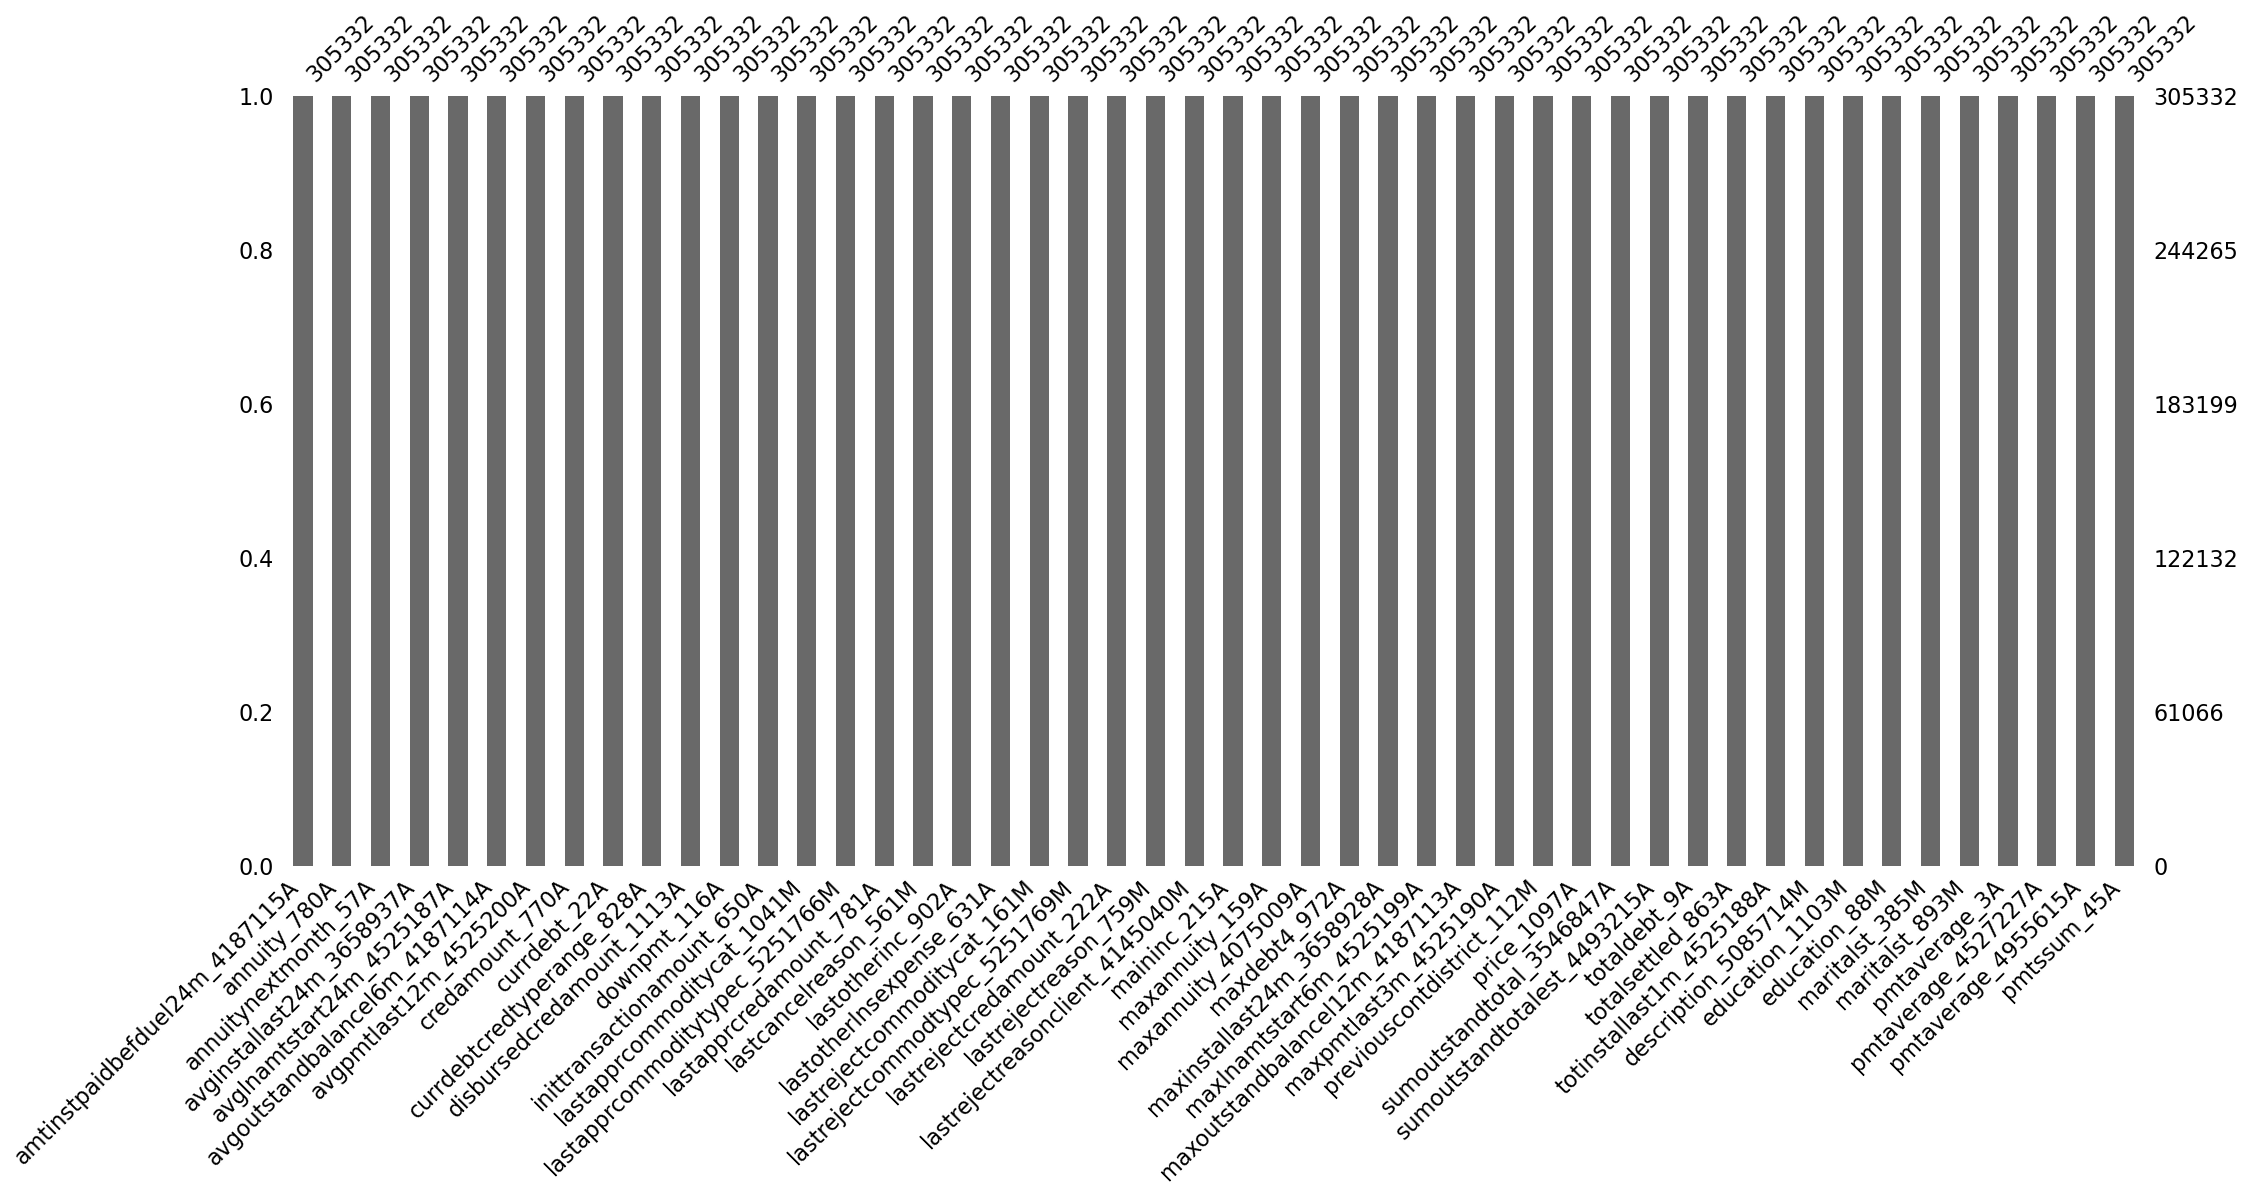

In [518]:
msno.bar(X_test)

In [519]:
# print out the shape of X_train, y_train, base_train,  X_test, y_test, base_test

print(X_train.shape, y_train.shape, base_train.shape, X_test.shape, y_test.shape, base_test.shape)

(1189973, 48) (1189973,) (1189973, 3) (305332, 48) (305332,) (305332, 3)


## Data Cleaning Done

### Scaling

In [520]:
# Calculate the min and max of each column
min_values = X_train.min()
max_values = X_train.max()

# Create a DataFrame from the min and max values
summary = pd.DataFrame({'Min': min_values, 'Max': max_values})

# Print the summary
print(summary)

                                          Min         Max
amtinstpaidbefduel24m_4187115A           -1.0   1408010.2
annuity_780A                             83.0    106007.0
annuitynextmonth_57A                     -1.0     87500.0
avginstallast24m_3658937A                -1.0    496148.8
avglnamtstart24m_4525187A                -1.0    513520.0
avgoutstandbalancel6m_4187114A           -1.0   1131135.9
avgpmtlast12m_4525200A                   -1.0    495910.4
credamount_770A                        2000.0    600000.0
currdebt_22A                             -1.0   1210629.1
currdebtcredtyperange_828A               -1.0   1029392.8
disbursedcredamount_1113A                 0.0    600000.0
downpmt_116A                              0.0    420400.0
inittransactionamount_650A               -1.0    200000.0
lastapprcommoditycat_1041M        P100_96_175    a55475b1
lastapprcommoditytypec_5251766M  P100_118_186    a55475b1
lastapprcredamount_781A                  -1.0    400000.0
lastcancelreas

In [521]:
#Scale

from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume X_train is a pandas DataFrame
num_cols = X_train.select_dtypes(include=[np.number]).columns

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the numerical columns of the training data and transform them
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Transform the numerical columns of the test data using the same scaler
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [522]:
# Calculate the min and max of each column
min_values = X_train.min()
max_values = X_train.max()

# Create a DataFrame from the min and max values
summary = pd.DataFrame({'Min': min_values, 'Max': max_values})

# Print the summary
print(summary)

                                          Min         Max
amtinstpaidbefduel24m_4187115A      -0.568059   21.593137
annuity_780A                        -1.314739   33.917182
annuitynextmonth_57A                 -0.51378   30.474058
avginstallast24m_3658937A           -0.569814   88.021212
avglnamtstart24m_4525187A           -0.239794   24.973734
avgoutstandbalancel6m_4187114A      -0.435094   22.750096
avgpmtlast12m_4525200A              -0.350994   81.691919
credamount_770A                     -1.083664   12.481777
currdebt_22A                        -0.387879   23.173643
currdebtcredtyperange_828A          -0.298942   27.398914
disbursedcredamount_1113A           -1.085091   13.054106
downpmt_116A                        -0.134734  102.194139
inittransactionamount_650A          -0.257926   12.155351
lastapprcommoditycat_1041M        P100_96_175    a55475b1
lastapprcommoditytypec_5251766M  P100_118_186    a55475b1
lastapprcredamount_781A             -0.738321    10.51668
lastcancelreas

### Let's encoding for both X_train and X_test

In [523]:
from sklearn.preprocessing import OrdinalEncoder

# Specify the columns to be ordinal encoded
ordinal_cols = ['lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastcancelreason_561M','lastrejectcommoditycat_161M','lastrejectcommodtypec_5251769M','lastrejectreason_759M','lastrejectreasonclient_4145040M','previouscontdistrict_112M','description_5085714M','education_1103M','education_88M','maritalst_385M','maritalst_893M']  # replace with your column names

# Create the ordinal encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder and transform X_train
X_train = X_train.copy()
X_train[ordinal_cols] = encoder.fit_transform(X_train[ordinal_cols])

# Transform X_test using the same encoder
X_test = X_test.copy()
X_test[ordinal_cols] = encoder.transform(X_test[ordinal_cols])

### Let's start downsampling

### downsampling

In [524]:
import pandas as pd
from sklearn.utils import resample

y_train_before = y_train.copy()

# Combine X_train and y_train
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df[df[y_train.name]==0]
df_minority = df[df[y_train.name]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int((len(df_majority)/4)),     # to 1/4 of the original size
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separate X_train and y_train
X_train = df_downsampled.drop(y_train.name, axis=1)
y_train = df_downsampled[y_train.name]

# Remove the corresponding rows in base_train
base_train = base_train.loc[X_train.index]

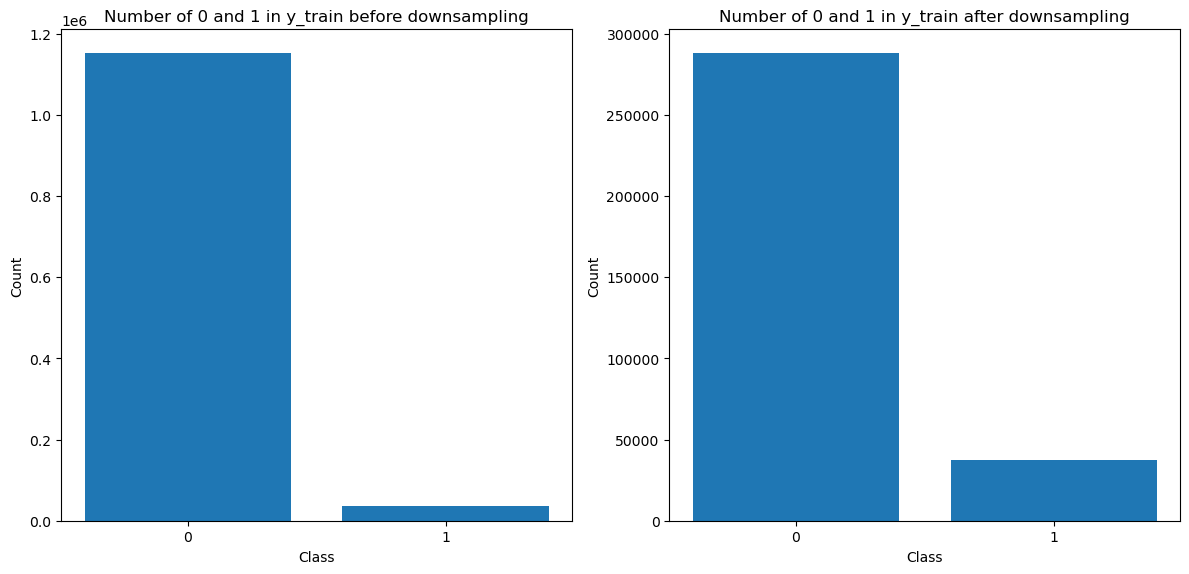

In [525]:
import matplotlib.pyplot as plt

# Assume y_train_before is y_train before downsampling
counts_before = y_train_before.value_counts()

# y_train is after downsampling
counts_after = y_train.value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot before downsampling
axs[0].bar(counts_before.index, counts_before.values)
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].set_title('Number of 0 and 1 in y_train before downsampling')
axs[0].set_xticks([0, 1])

# Plot after downsampling
axs[1].bar(counts_after.index, counts_after.values)
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')
axs[1].set_title('Number of 0 and 1 in y_train after downsampling')
axs[1].set_xticks([0, 1])

# Show the plot
plt.tight_layout()
plt.show()

### SMOTE after downsampling

In [526]:
from imblearn.over_sampling import SMOTE

# Define SMOTE
smote = SMOTE(random_state=123)
# Assume y_train_before is y_train before downsampling
counts_before = y_train.value_counts()

# Fit and apply smote
X_train, y_train = smote.fit_resample(X_train, y_train)

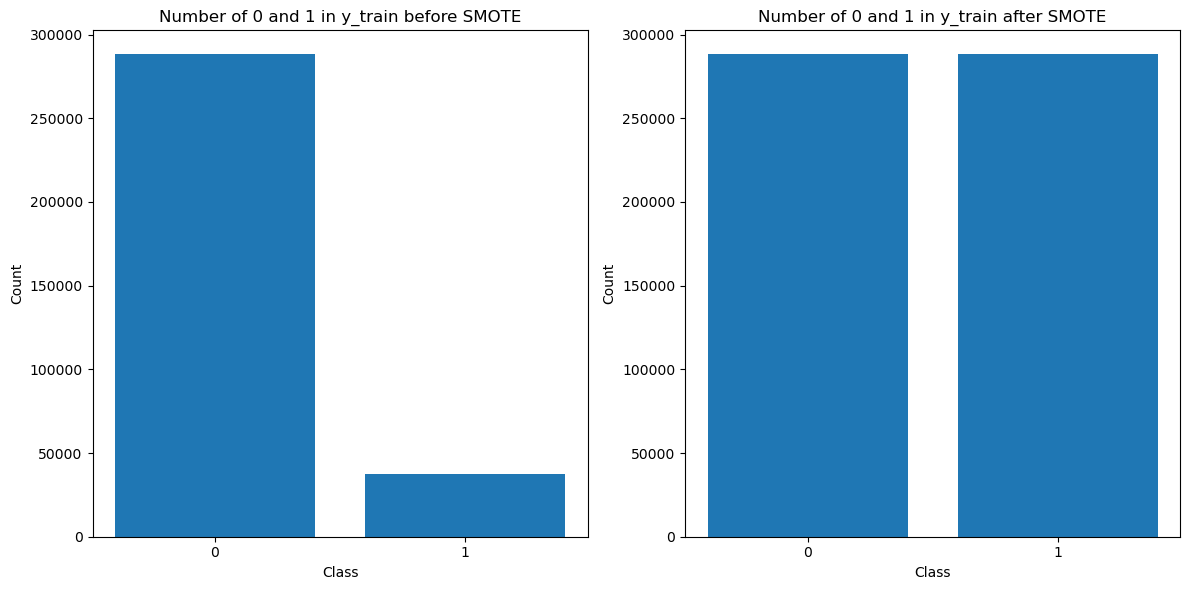

In [527]:
import matplotlib.pyplot as plt



# y_train is after downsampling
counts_after = y_train.value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot before downsampling
axs[0].bar(counts_before.index, counts_before.values)
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].set_title('Number of 0 and 1 in y_train before SMOTE')
axs[0].set_xticks([0, 1])

# Plot after downsampling
axs[1].bar(counts_after.index, counts_after.values)
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')
axs[1].set_title('Number of 0 and 1 in y_train after SMOTE')
axs[1].set_xticks([0, 1])

# Show the plot
plt.tight_layout()
plt.show()

## Let's train some model

### Decision Tree

In [528]:
# print out the shape of X_train, y_train, base_train,  X_test, y_test, base_test

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, base_test.shape)

(576246, 48) (576246,) (305332, 48) (305332,) (305332, 3)


In [529]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8149096720946379
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90    295689
           1       0.05      0.27      0.09      9643

    accuracy                           0.81    305332
   macro avg       0.51      0.55      0.49    305332
weighted avg       0.94      0.81      0.87    305332



### KNN

In [530]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the kNN Classifier model
# 'n_neighbors' is set to 5 as a starting point
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn_model.fit(X_train, y_train)

# Predict on the test data
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"kNN Classifier Accuracy: {accuracy_knn}")
print("kNN Classifier Classification Report:")
print(classification_report(y_test, y_pred_knn))


AttributeError: 'Flags' object has no attribute 'c_contiguous'

### Neural Network

In [531]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30),  # Example: one hidden layer with 100 neurons
                    activation='relu',  # Activation function for the hidden layer
                    solver='adam',  # Solver for weight optimization
                    max_iter=500,  # Maximum number of epochs
                    random_state=1,  # Seed for random number generator for reproducibility
                    learning_rate_init=0.001,
                    tol=0.000001,
                    verbose=True,
                    batch_size='auto',  # 'auto' means the batch size is min(200, n_samples)
                    ) 


mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred))

Iteration 1, loss = 0.71783864
Iteration 2, loss = 0.61902734
Iteration 3, loss = 0.60840941
Iteration 4, loss = 0.59970710
Iteration 5, loss = 0.59372486
Iteration 6, loss = 0.58912333
Iteration 7, loss = 0.58580736
Iteration 8, loss = 0.58149715
Iteration 9, loss = 0.57788420
Iteration 10, loss = 0.57426350
Iteration 11, loss = 0.57078975
Iteration 12, loss = 0.56730423
Iteration 13, loss = 0.56403708
Iteration 14, loss = 0.55937098
Iteration 15, loss = 0.55535446
Iteration 16, loss = 0.55128961
Iteration 17, loss = 0.54699204
Iteration 18, loss = 0.54231934
Iteration 19, loss = 0.53756683
Iteration 20, loss = 0.53430502
Iteration 21, loss = 0.53177563
Iteration 22, loss = 0.52888407
Iteration 23, loss = 0.52645224
Iteration 24, loss = 0.52464410
Iteration 25, loss = 0.52336124
Iteration 26, loss = 0.52114941
Iteration 27, loss = 0.51916743
Iteration 28, loss = 0.51815381
Iteration 29, loss = 0.51693544
Iteration 30, loss = 0.51523159
Iteration 31, loss = 0.51486912
Iteration 32, los